# Simulating single component Lennard-Jones with rumdpy 

Features included:
- choice between several integrators
- cooling ramp giving insight into phase behavior
- on-the-fly 3D visualization

In [30]:
# Reproducing 'ATU' run in phd1:
#    LJ, N=864, rho=0.60, cooling from T=3.0 to 0.1 with dt=0.005, 
#    scalars: every 20'th step, trajectory: 194 log-blocks    
#
# Timestep                                       200_000            2_000_000
# Rumd3 GeForce GTX TITAN, 5.5 TFlops, runtime: 56   sec            196   sec
# rumdpy RTX 3070 Laptop, 11.4 TFlops, runtime:  8.2 (4.7) sec       41.0 (37.1) sec (trajectories not yet included)
# rumdpy RTX 3070 Laptop, 11.4 TFlops, runtime: 10.0 sec (256_000)   39.9 sec (1000 conf_blocks)

## Imports

In [31]:
import numpy as np
import numba
import math
from numba import cuda

# rumdpy
import rumdpy as rp
from rumdpy.integrators import nve, nve_toxvaerd, nvt, nvt_langevin, npt_langevin
from analyze_LJ import analyze_LJ

# IO
import pandas as pd
import pickle
import sys
import h5py

# Plotting and visualization
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

import k3d
from k3d.colormaps import matplotlib_color_maps
import ipywidgets as widgets

## Generate configuration with a FCC lattice

In [32]:
c1 = rp.make_configuration_fcc(nx=6,  ny=6,  nz=6,  rho=0.60,  T=3.44)      # N = 4*6**3   =  864
#c1 = rp.make_configuration_fcc(nx=8,  ny=8,  nz=8,  rho=0.60,  T=3.44)      # N = 4*6**3   =  864
#c1 = rp.make_configuration_fcc(nx=16,  ny=4,  nz=4,  rho=0.60,  T=3.44)    # N = 4*18*6*6 = 2592
c1.copy_to_device() 

# Get a 'compute-plan', i.e. parameters determining how simulations are performed on the GPU
compute_plan = rp.get_default_compute_plan(c1)
print('compute_plan:', compute_plan)

compute_plan: {'pb': 8, 'tp': 16, 'skin': 0.5, 'UtilizeNIII': False, 'gridsync': True}


## Setup Lennard-Jones pair potential

In [33]:
pair_potential = rp.apply_shifted_force_cutoff(rp.make_LJ_m_n(12,6))
params = [[[4.0, -4.0, 2.5],], ]
LJ = rp.PairPotential(c1, pair_potential, params=params, max_num_nbs=1000, compute_plan=compute_plan)
pairs = LJ.get_interactions(c1, exclusions=None, compute_plan=compute_plan, verbose=False)

## Setup output managers

In [34]:
steps_between_output = 16
output_calculator = rp.make_scalar_calculator(c1, steps_between_output, compute_plan)

conf_saver = rp.make_conf_saver(c1, compute_plan)

## Setup RDF (Radial Distribution Function) calculator

In [35]:
include_rdf = True
if include_rdf:
    num_bins = 500
    full_range=True
    gr_bins_zeros = np.zeros(num_bins, dtype=np.float64) # float64 good / necessary
    d_gr_bins = cuda.to_device(gr_bins_zeros)
       
    rdf_calculator = rp.make_rdf_calculator(c1, pair_potential = LJ, compute_plan=compute_plan, full_range=full_range, verbose=True)  

## Setup integrator

In [36]:
dt = 0.005 # timestep (MOVE from setup to call)
outer_steps = 1000   # Do simulation in this many 'blocks'
inner_steps = 2*1024  # ... each of this many steps
#inner_steps = 256  # ... each of this many steps
running_time = dt*inner_steps*outer_steps

integrator = 'NVT'

Thigh = 2.0
Tlow  = 0.3

# Setup functions to control temperature and pressure (only for NPT)
T0 = rp.make_function_constant(value=Thigh) # Not used for NVE*
P0 = rp.make_function_constant(value=0.0) # Not used for NV*
#T1 = rp.make_function_ramp(value0=2.0, x0=0.0, value1=0.01, x1=dt*inner_steps*outer_steps)
T1 = rp.make_function_ramp(value0=Thigh, x0=running_time*(1/4), value1=Tlow, x1=running_time*(3/4))


In [37]:
# Integrator for equilibration
integrate0, integrator_params0 = nvt.setup_output(c1, pairs['interactions'], None, None, T0, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False) 

# Interrator for production
if integrator=='NVE':
    integrate, integrator_params = nve.setup_output(c1, pairs['interactions'], output_calculator, dt=dt, compute_plan=compute_plan, verbose=False)

if integrator=='NVE_Toxvaerd':
    integrate, integrator_params = nve_toxvaerd.setup_output(c1, pairs['interactions'], output_calculator, dt=dt, compute_plan=compute_plan, verbose=False)

if integrator=='NVT':
    integrate, integrator_params = nvt.setup_output(c1, pairs['interactions'], output_calculator, conf_saver, T1, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False) 
        
if integrator=='NVT_Langevin':
    integrate, integrator_params = nvt_langevin.setup_output(c1, pairs['interactions'], output_calculator, T1, alpha=0.1, dt=dt, seed=2023, compute_plan=compute_plan, verbose=False)

if integrator=='NPT_Langevin':
    integrate, integrator_params = npt_langevin.setup_output(c1, pairs['interactions'],  output_calculator, T1, P0, alpha=0.1, alpha_baro=0.0001, 
        mass_baro=0.0001, volume_velocity=0.0, barostatModeISO = True , boxFlucCoord = 2, dt=dt, seed=2023, compute_plan=compute_plan, verbose=False)


## Initialize storing output

In [38]:
memory_blocks = True
hdf5_blocks = True
hdf5virtual_blocks = True

conf_per_block = int(math.log2(inner_steps))+2 # carefull!!!
num_vectors = 2 # 'r' and 'r_im'

print('Configurations per block (log2-storing):', conf_per_block)

if memory_blocks:
    print(f'Storing conf blocks in memory. Expected footprint {outer_steps*conf_per_block*num_vectors*c1.N*c1.D*4/1024/1024:.2f} MB.')
    conf_blocks = np.zeros((outer_steps, conf_per_block, num_vectors, c1.N, c1.D), dtype=np.float32)
    print(f'Actual footprint: {conf_blocks.nbytes/1024/1024:.2f} MB.')

if hdf5_blocks:
    with h5py.File("Data/LJ_trajectory.h5", "w", libver="latest") as f:
        dset = f.create_dataset("block", shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D,), chunks=(1, 1, num_vectors, c1.N, c1.D), dtype=np.float32)
        #dset = f.create_dataset("block", shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D,), chunks=(1, 1, num_vectors, c1.N, c1.D), dtype=np.float32, compression="gzip")
        #dset = f.create_dataset("block", shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D,), dtype=np.float32)
        
if hdf5virtual_blocks:
    # Assemble virtual dataset
    # modified from: https://github.com/h5py/h5py/blob/master/examples/vds_simple.py
    layout = h5py.VirtualLayout(shape=(outer_steps, conf_per_block, num_vectors, c1.N, c1.D), dtype=np.float32)
    for n in range(outer_steps):
        filename = f"Data/LJ_trajectory/conf_block_{n:05d}.h5"
        layout[n] = h5py.VirtualSource(filename, "block", shape=(conf_per_block, num_vectors, c1.N, c1.D,))
    
    # Add virtual dataset to output file
    with h5py.File("Data/LJ_trajectory_vir.h5", "w", libver="latest") as f:
        f.create_virtual_dataset("block", layout, fillvalue=0)
        


Configurations per block (log2-storing): 13
Storing conf blocks in memory. Expected footprint 257.08 MB.
Actual footprint: 257.08 MB.


## Initialize 3D visualization

In [39]:
plt_points = k3d.points(positions=c1['r'],
                        point_sizes=np.ones((c1.N),dtype=np.float32),
                        #shader='3dSpecular',
                        #shader='3d',
                        shader='mesh',
                        color_map=matplotlib_color_maps.Jet,
                        attribute=c1.scalars[:,0],
                        color_range=[-6, 0],
                        name='Atoms'
                       )
Lx, Ly, Lz = c1.simbox.data
plt_box = k3d.lines(vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                              [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                              [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                              [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]], 
                    indices=[[0,1], [0,2], [0,3], 
                            [1,4], [1,5], [2,4], [2,6], [3,5], [3,6],
                            [7,4], [7,5], [7,6]], 
                    indices_type='segment',
                    shader='mesh', width=min((Lx, Ly, Lz))/100, 
                    name='Simulation Box'
                   )


plt_time_text = k3d.text2d('Time: ', position=[0.01, 0.15], is_html=True)
plt_temp_text = k3d.text2d('Temperature: ', position=[0.01, 0.25], is_html=True,)
plt_fn_text = k3d.text2d('Potential:', position=[0.01, 0.42], is_html=True)

plot = k3d.plot(camera_mode='orbit', camera_fov=3.0,)
plot += plt_points
plot += plt_box
plot += plt_fn_text + plt_time_text + plt_temp_text
#plot.display()

In [40]:
def update_3D(index, choice):
    plt_points.positions = conf_list[index]
    model_time = (index+1)*dt*inner_steps
    plt_time_text.text = f'Time: {model_time:.2f}'
    plt_temp_text.text = f'Temp: {T1(model_time):.3f}'
    plt_points.attribute = scalars_list[index][:,choice]
    Lx, Ly, Lz = c1.simbox.data
    plt_box.vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                      [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                      [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                      [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]],
    
def set_color_range(choice):
    plt_points.color_range=np.percentile(scalars_list[:,:,choice], (1, 99))
        
play = widgets.Play(
    value=outer_steps-1,
    min=0,
    max=outer_steps-1,
    step=1,
    interval=0,
    description="Press play",
    disabled=False
)

attribute_dropdown = widgets.Dropdown(
    options=[('Potential energy', 0), ('Virial', 1), ('Laplace U', 2), ('m', 3), ('Kinetic energy', 4), ('F^2', 5)],
    value=0,
    description='Color:',
    disabled=False,
)

slider = widgets.IntSlider(description='Frame:', max=play.max)
widgets.jslink((play, 'value'), (slider, 'value'))

w0 = widgets.interactive(update_3D, index=play, choice=attribute_dropdown)
w1 = widgets.interactive(set_color_range, choice=attribute_dropdown)

## Scale configuration to desired density 

In [41]:
%%time

# Scale to desired density
target_density = 0.60
c1.copy_to_host()
current_density = c1.N/np.prod(c1.simbox.data)
scale_factor = (current_density/target_density)**(1/3)
c1['r'] *= scale_factor
c1.simbox.data *= scale_factor
c1.copy_to_device()

CPU times: user 4.61 ms, sys: 9.89 ms, total: 14.5 ms
Wall time: 13.8 ms


## Run Simulation 

In [42]:
def run(num_blocks):
    # Inializing run
    # Store simulation parameters for use in post run analysis
    sim_params = {'N':c1.N, 'D':c1.D, 'simbox':c1.simbox.data, 'integrator':integrator, 'rdf':include_rdf}
    print('sim_params:', sim_params)
    with open('Data/LJ_pdict.pkl', 'wb') as f:
        pickle.dump(sim_params, f)

    num_conf = round(math.log2(inner_steps)+2)
    print('num_conf:', num_conf)
    zero_conf_array = np.zeros((num_conf, 2, c1.N, c1.D), dtype=np.float32)
    d_conf_array = cuda.to_device(zero_conf_array)

    zero_output_array = np.zeros((inner_steps//steps_between_output, 5), dtype=np.float32)
    d_output_array = cuda.to_device(zero_output_array) 
    d_gr_bins = cuda.to_device(gr_bins_zeros)

    # "Equilibrate"
    integrate0(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  
           pairs['interaction_params'], integrator_params0, d_output_array, d_conf_array, np.float32(0), inner_steps)

#    scalars_t = []
    tt = []
    #vol_t = []
    conf_list = []
    scalars_list = []
    gr_bins = [] 

    start = cuda.event()
    end = cuda.event()
    zero = np.float32(0.0)

    start.record() 
    
    for block in range(num_blocks):
        d_output_array = cuda.to_device(zero_output_array) # Set output array to zero. Could probably be done faste
        d_conf_array = cuda.to_device(zero_conf_array) # not needed every block, since should overwrite
        integrate(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  pairs['interaction_params'], integrator_params, d_output_array, d_conf_array, np.float32(block*inner_steps*dt), inner_steps)
        
        scalars_t.append(d_output_array.copy_to_host())        
        
        if memory_blocks or hdf5_blocks or hdf5virtual_blocks:
            block_array = d_conf_array.copy_to_host()
            
        if memory_blocks:
            conf_blocks[block] = block_array
            
        if hdf5_blocks:
            with h5py.File(f"Data/LJ_trajectory.h5", "a") as f:
                f['block'][block,:] = block_array
                
        if hdf5virtual_blocks:
            with h5py.File(f"Data/LJ_trajectory/conf_block_{block:05d}.h5", "w") as f:
                f.create_dataset("block", (conf_per_block, num_vectors, c1.N, c1.D,), "float32", block_array)
        
        vol = (c1.simbox.data[0] * c1.simbox.data[1] * c1.simbox.data[2])
        vol_t.append(vol)

        if include_rdf:
            rdf_calculator(c1.d_vectors, c1.simbox.d_data, c1.d_ptype, pairs['interaction_params'], d_gr_bins)
            gr_bins.append(d_gr_bins.copy_to_host())
            d_gr_bins = cuda.to_device(gr_bins_zeros)

        yield block
    
    # Finalizing run
    end.record()
    end.synchronize()
    timing_numba = cuda.event_elapsed_time(start, end)
    nbflag = LJ.nblist.d_nbflag.copy_to_host()    
    tps = outer_steps*inner_steps/timing_numba*1000
    output_array = d_output_array.copy_to_host()
    scalars_list = np.array(scalars_list)
    
    print('\tsteps :', outer_steps*inner_steps)
    print('\tnbflag : ', nbflag)
    print('\ttime :', timing_numba/1000, 's')
    print('\tTPS : ', tps )
    print('\tfinal box dims : ', c1.simbox.data[0], c1.simbox.data[1], c1.simbox.data[2])

In [43]:
conf_list = []
scalars_list = []
scalars_t = []
vol_t = []
plt_points.color_range=[-6, 0]
plot.display()

for i in run(outer_steps):
    # Update 3D visualizaton
    c1.copy_to_host()
    conf_list.append(c1['r'])
    scalars_list.append(c1.scalars)
    update_3D(i, 0)
    
display(widgets.HBox([play, slider, attribute_dropdown]))

 

Output()

sim_params: {'N': 864, 'D': 3, 'simbox': array([11.292433, 11.292433, 11.292433], dtype=float32), 'integrator': 'NVT', 'rdf': True}
num_conf: 13
	steps : 2048000
	nbflag :  [     0      0 158015]
	time : 43.08743359375 s
	TPS :  47531.25979397089
	final box dims :  11.292433 11.292433 11.292433


In [21]:
plt_fn_text.text = 'u'
attribute = c1.scalars[:,0]
print(np.mean(attribute), np.std(attribute), min(attribute), max(attribute))
plt_points.attribute = attribute
plt_points.color_range=[min(attribute), max(attribute)]

-5.6804967 0.932488 -6.7433558 -2.4491656


## Write results to disc

In [28]:
if type(scalars_t) == list:
    scalars_t = np.concatenate(scalars_t)

# Save data
df = pd.DataFrame(scalars_t, columns=['u', 'w', 'lap', 'fsq', 'k'], dtype=np.float32)
df['t'] = np.array(np.arange(scalars_t.shape[0])*dt*steps_between_output, dtype=np.float32)
df['vol'] = vol_t[0]
if integrator[0:3]!='NVE':
    df['Ttarget'] = numba.vectorize(T1)(np.array(df['t']))
if integrator=='NPT_Langevin':
    df['Ptarget'] = numba.vectorize(P0)(np.array(df['t'])) 
df.to_csv('Data/LJ_scalars.csv', index=False)


In [29]:
if include_rdf:
    if type(gr_bins) == list:
         gr_bins = np.array(gr_bins)
         data = rp.normalize_and_save_gr_multi(gr_bins, c1, pairs['interaction_params'], full_range, filename='Data/LJ_rdf.dat')

NameError: name 'gr_bins' is not defined

In [ ]:
%%time 
np.save('Data/LJ_scalars.npy', scalars_t)

In [ ]:
%%time 
scalars_t.shape
dfn = np.load('Data/LJ_scalars.npy')
df = pd.DataFrame(dfn, columns=['u', 'w', 'lap', 'fsq', 'k'], dtype=np.float32)

In [ ]:
%%time
#!rm Data/LJ_scalars_.h5
with h5py.File('Data/LJ_scalars_.h5', 'w') as f:
    f['scalars'] = scalars_t[:,:]
    f['vectors'] = c1.vectors.array

In [ ]:
%%time
f = h5py.File('Data/LJ_scalars_.h5', 'r')
x = np.array(f['scalars'])
C = np.array(f['vectors'])

## Data analysis

Only using data stored on disc, i.e. the following could/should be separated into its own notebook

In [44]:
import numpy as np
import rumdpy as rp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

u           -3323.351469
w             308.436977
lap        542990.078603
fsq        622078.850171
k            1488.706553
t            5119.960000
vol          1440.000100
Ttarget         1.150007
dtype: float64


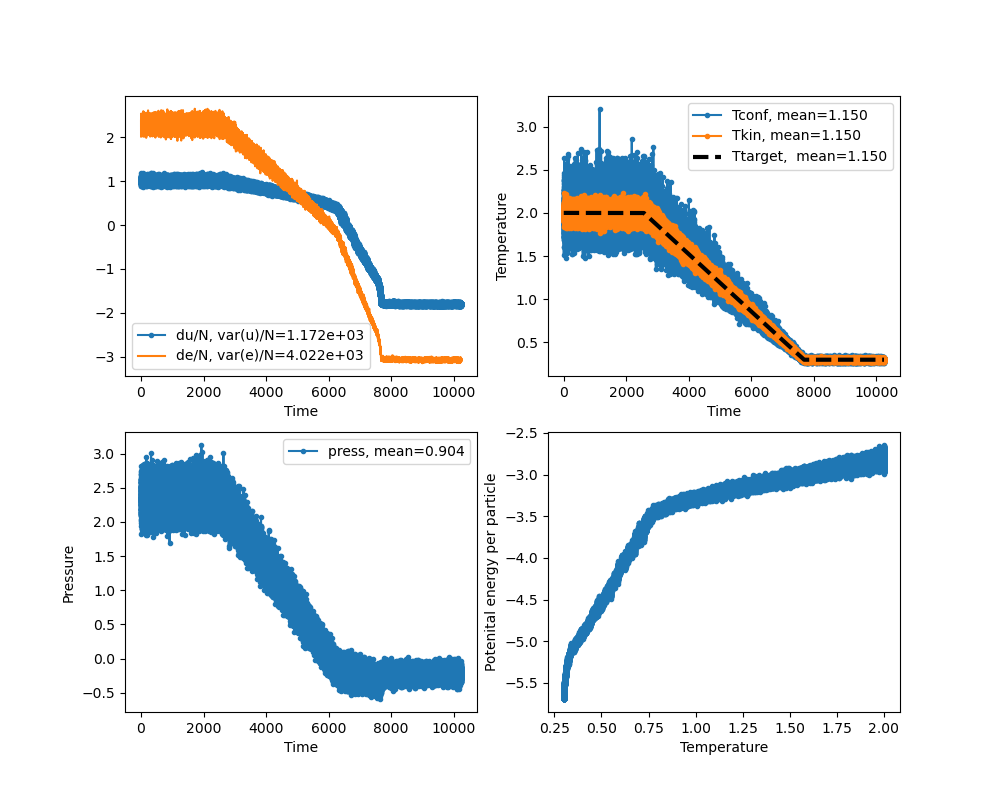

In [45]:
with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)
df = pd.read_csv('Data/LJ_scalars.csv', index_col=False)
#print(df)
print(df.mean())
rp.plot_scalars(df, pdict['N'],  pdict['D'], figsize=(10,8), block=True)

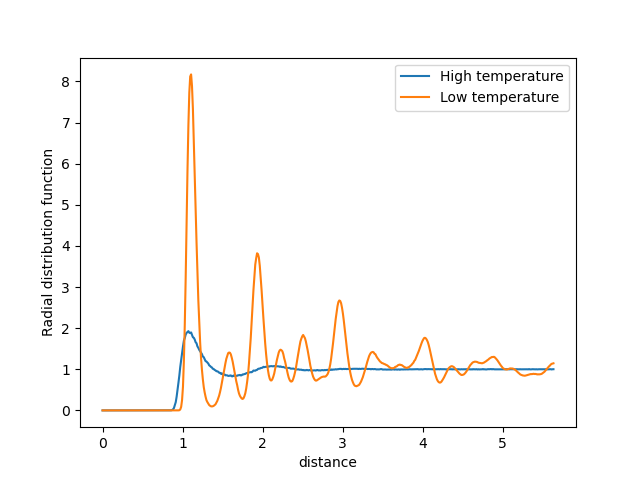

In [47]:
with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)

if pdict['rdf']:
    rdf = np.loadtxt('Data/LJ_rdf.dat')
    plt.figure()
    plt.plot(rdf[:,0], np.mean(rdf[:, 50: 250], axis=1), label='High temperature')
    plt.plot(rdf[:,0], np.mean(rdf[:,800:1000], axis=1), label='Low temperature')
    plt.xlabel('distance')
    plt.ylabel('Radial distribution function')
    plt.legend()
    plt.show(block=False)

In [48]:
def calc_msd(conf_array, dt, simbox_data):
    
    num_blocks, conf_per_block = conf_array.shape[0:2]
    msd = np.zeros((conf_per_block-1, 2))
    m4d = np.zeros((conf_per_block-1, 2))
    
    for block in range(0, num_blocks):
        for i in range(conf_per_block-1):
            msd[i,0] += dt*2**i
            dR =   conf_array[block,i+1,0,:,:] - conf_array[block,0,0,:,:]
            dR += (conf_array[block,i+1,1,:,:] - conf_array[block,0,1,:,:])*simbox_data
            msd[i,1] += np.mean(np.sum(dR**2, axis=1))
            m4d[i,1] += np.mean(np.sum(dR**2, axis=1)**2)
    
    msd /= num_blocks
    m4d /= num_blocks
    alpha2 = msd.copy()
    alpha2[:,1] = 3*m4d[:,1]/(5*msd[:,1]**2) - 1 
    return msd, alpha2

In [26]:
%%time
if hdf5virtual_blocks:
    with h5py.File("Data/LJ_trajectory_vir.h5", "r") as f:
        msd_high, a2_high = calc_msd(f['block'][ 50:250], dt, c1.simbox.data) # dt, c1.simbox.data should be read from file
        msd_low,  a2_low  = calc_msd(f['block'][800:999], dt, c1.simbox.data) # dt, c1.simbox.data should be read from file

CPU times: user 1.06 s, sys: 67.2 ms, total: 1.13 s
Wall time: 1.21 s


In [27]:
%%time
if hdf5virtual_blocks:
    with h5py.File("Data/LJ_trajectory.h5", "r") as f:
        msd_high, a2_high = calc_msd(f['block'][ 50:250], dt, c1.simbox.data) # dt, c1.simbox.data should be read from file
        msd_low,  a2_low  = calc_msd(f['block'][800:999], dt, c1.simbox.data) # dt, c1.simbox.data should be read from file

CPU times: user 288 ms, sys: 13.1 ms, total: 301 ms
Wall time: 299 ms


In [49]:
%%time
if memory_blocks:
    print(f'conf_blocks: {conf_blocks.shape}, {conf_blocks.nbytes/1024/1024:.2f} MB')
    msd_high, a2_high = calc_msd(conf_blocks[ 50:250], dt, c1.simbox.data) # dt, c1.simbox.data should be read from file
    msd_low,  a2_low  = calc_msd(conf_blocks[800:999], dt, c1.simbox.data) # dt, c1.simbox.data should be read from file

conf_blocks: (1000, 13, 2, 864, 3), 257.08 MB
CPU times: user 242 ms, sys: 0 ns, total: 242 ms
Wall time: 242 ms


In [50]:
!ls -lh Data/LJ_trajectory.h5

-rw-rw-r-- 1 tbs tbs 258M Jan 18 13:10 Data/LJ_trajectory.h5


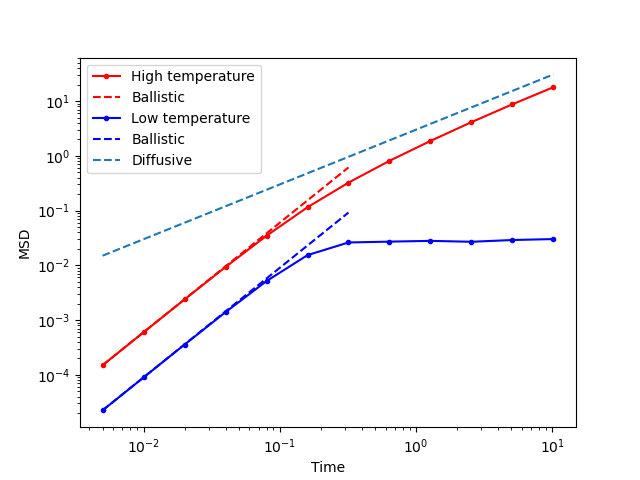

In [51]:
plt.figure()
plt.loglog(msd_high[:,0], msd_high[:,1], 'r.-', label='High temperature' )
plt.loglog(msd_low[:7,0], 3*Thigh*msd_low[:7,0]**2, 'r--', label='Ballistic')
plt.loglog(msd_low[:,0], msd_low[:,1], 'b.-', label='Low temperature')
plt.loglog(msd_low[:7,0], 3*Tlow*msd_low[:7,0]**2, 'b--', label='Ballistic')
plt.loglog(msd_low[:,0], msd_low[:,0]*3, '--', label='Diffusive')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.legend()
plt.show()

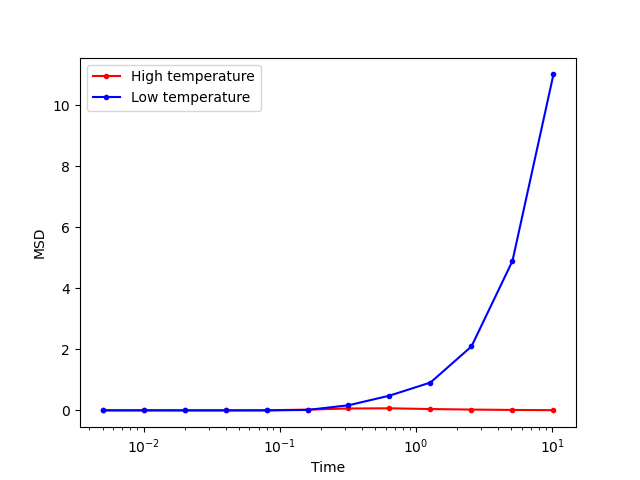

In [30]:
plt.figure()
plt.semilogx(a2_high[:,0], a2_high[:,1], 'r.-', label='High temperature' )
plt.semilogx(a2_low[:,0], a2_low[:,1], 'b.-', label='Low temperature' )
plt.xlabel('Time')
plt.ylabel('MSD')
plt.legend()
plt.show()